In [281]:
import os
import sys
import numpy as np
import cv2
import scipy.io

import matplotlib.pyplot as plt
%matplotlib inline

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms, datasets

import time
import warnings
warnings.filterwarnings('ignore')

# self-class
from ITrackerModel import ITrackerModel

In [282]:
path = '/home/kerrykim/jupyter_notebook/5. eyetracking/tmp/'

faceDet = cv2.CascadeClassifier(path + "haarcascade_frontalface_default.xml")
faceDet_two = cv2.CascadeClassifier(path + "haarcascade_frontalface_alt2.xml")
faceDet_three = cv2.CascadeClassifier(path + "haarcascade_frontalface_alt.xml")
faceDet_four = cv2.CascadeClassifier(path + "haarcascade_frontalface_alt_tree.xml")

face_cascade = cv2.CascadeClassifier(path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(path + 'haarcascade_eye.xml')

In [283]:
def current_time():
    return int(round(time.time() * 1000))

def detect_eyes(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    eyes_sorted_by_size = sorted(eyes, key=lambda x: -x[2])
    largest_eyes = eyes_sorted_by_size[:2]
    # sort by x position
    largest_eyes.sort(key=lambda x: x[0])
    # offset by face start
    return list(map(lambda eye: [face[0] + eye[0], face[1] + eye[1], eye[2], eye[3]], largest_eyes))

def get_face_grid(face, frameW, frameH, gridSize):
    faceX,faceY,faceW,faceH = face

    return faceGridFromFaceRect(frameW, frameH, gridSize, gridSize, faceX, faceY, faceW, faceH, False)

def extract_image_features(image_path):
    img = cv2.imread(image_path)
    start_ms = current_time()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
    # cascade chain building (--여기서부터 수정--)
    #face_detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    # face detection minSize를 50으로 해서 너무 작은 얼굴을 detection하는 걸 피한다.
    
    face = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5))
    face_two = faceDet_two.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5))
    face_three = faceDet_three.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5))
    face_four = faceDet_four.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5))
    
    if len(face) == 1:
        face_detections = face
    elif len(face_two) == 1:
        face_detections = face_two
    elif len(face_three) == 1:
        face_detections = face_three
    elif len(face_four) == 1:
        face_detections = face_four
    else:
        face_detections = ""
    
    # (--수정완료--)
    

    left_to_right_face_detections = sorted(face_detections, key=lambda detection: detection[0])

    faces = []
    face_features = []
    for [x,y,w,h] in left_to_right_face_detections:
        face = [x, y, w, h]
        #  start_eyes = current_time()
        eyes = detect_eyes(face, img, gray)
        #  print('eye extraction '  + str((current_time() - start_eyes) / 1000.))
        face_grid = get_face_grid(face, img.shape[1], img.shape[0], 25)

        faces.append(face)
        face_features.append([eyes, face_grid])

    duration_ms = current_time() - start_ms
    #  print("Face and eye extraction took: ", str(duration_ms / 1000) + "s")

    return img, faces, face_features

In [284]:
def faceGridFromFaceRect(frameW, frameH, gridW, gridH, labelFaceX, labelFaceY, labelFaceW, labelFaceH, parameterized):

    scaleX = gridW / frameW
    scaleY = gridH / frameH
    
    if parameterized:
      labelFaceGrid = np.zeros(4)
    else:
      labelFaceGrid = np.zeros(gridW * gridH)
    
    grid = np.zeros((gridH, gridW))

    # Use one-based image coordinates.
    xLo = round(labelFaceX * scaleX)
    yLo = round(labelFaceY * scaleY)
    w = round(labelFaceW * scaleX)
    h = round(labelFaceH * scaleY)

    if parameterized:
        labelFaceGrid = [xLo, yLo, w, h]
    else:
        xHi = xLo + w
        yHi = yLo + h

        # Clamp the values in the range.
        xLo = int(min(gridW, max(0, xLo)))
        xHi = int(min(gridW, max(0, xHi)))
        yLo = int(min(gridH, max(0, yLo)))
        yHi = int(min(gridH, max(0, yHi)))

        faceLocation = np.ones((yHi - yLo, xHi - xLo))
        grid[yLo:yHi, xLo:xHi] = faceLocation

        # Flatten the grid.
        grid = np.transpose(grid)
        labelFaceGrid = grid.flatten()
        
    return labelFaceGrid

In [285]:
def set_title_and_hide_axis(title):
    plt.title(title)
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)

def render_face_grid(face_grid):
    to_print = np.copy(face_grid)
    result_image = np.copy(to_print).reshape(25, 25).transpose()
    plt.figure()
    set_title_and_hide_axis('Face grid')
    plt.imshow(result_image)

def show_extraction_results(img, faces, face_features):
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    for i, face in enumerate(faces):
        print('Face #' + str(i))
        eyes, face_grid = face_features[i]
        [x, y, w, h] = face
        set_title_and_hide_axis('Extracted face image')
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        for [ex,ey,ew,eh] in eyes:
            cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))    # before, plt.figure()
        render_face_grid(face_grid)
    

Face #0


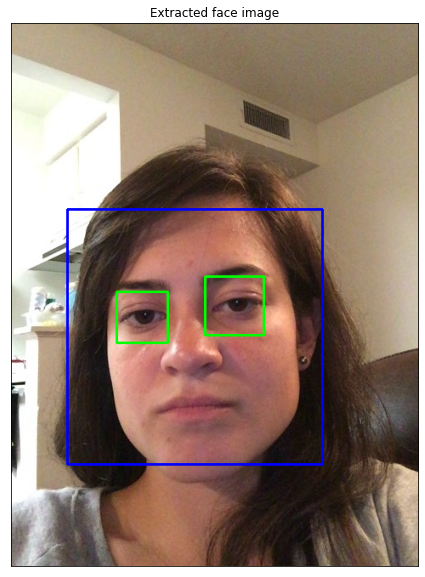

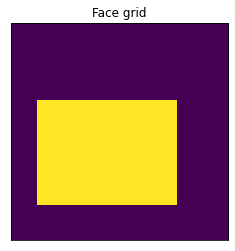

In [286]:
#image_path = '/home/kerrykim/jupyter_notebook/5. eyetracking/dataset_test/right_down.jpg'
image_path = '/home/kerrykim/PycharmProjects/eyetracking_origin/dataset_origin/02131/frames/00850.jpg'

img, faces, face_features = extract_image_features(image_path)

#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

show_extraction_results(img, faces, face_features)

In [287]:
path = '/home/kerrykim/jupyter_notebook/5. eyetracking/tmp/'

fn_tonumpy = lambda x: x.to('cpu').detach().numpy()

def flatten(lst):
    result = []
    for item in lst:
        result.extend(item)
    return result

# Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ITrackerModel().to(device)

# Optimizer
optim = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)


saved = torch.load('/home/kerrykim/jupyter_notebook/5. eyetracking/tmp/checkpoint.pth.tar')

state = saved['state_dict']

model.load_state_dict(state) # 이과정은 model = model.load_state_dict로 원하는 모델이란 기능의 변수를 생성할 수 없다.

epoch = saved['epoch']
best_prec1 = saved['best_prec1']

In [288]:
model

ITrackerModel(
  (eyeModel): ItrackerImageModel(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1.0)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1.0)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (faceModel): FaceImageModel(
    (conv): ItrackerImageModel(
      (features): Sequential(
        (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
        (1): ReLU(inplace=True)
        (2): MaxPoo

In [304]:
# load the mean images
import scipy.io

def get_mean_image(file_name):
    image_mean = np.array(scipy.io.loadmat(path + file_name)['image_mean'])
    image_mean = image_mean.reshape(3, 224, 224)
    
    return image_mean.mean(1).mean(1)

faceMean = get_mean_image('mean_face_224.mat')
eyeLeftMean = get_mean_image('mean_left_224.mat')
eyeRightMean = get_mean_image('mean_right_224.mat')

[118.74723 129.16585 113.75103]


In [290]:
class ToPILImage(object):
    def __call__(self, input):

        input = transforms.ToPILImage()(input)
        
        return input
    
class ToNumpy(object):
    def __call__(self, input):
        return np.array(input)
    
class SubtractMean(object):
    def __init__(self, meanImg):
        self.meanImg = meanImg

    def __call__(self, input):
        input = input - self.meanImg
        return input
    
    
class ToTensor(object):
    def __call__(self, input):
        if input.ndim == 2:
            input = input[:, :, np.newaxis]
            
        input = np.moveaxis(input[:, :, :], -1, 0)
        input = torch.from_numpy(input / 255)
        input = input.unsqueeze(0)
        
        return input

In [291]:
def crop_image(img, crop):
    return img[crop[1]:crop[1]+crop[3],crop[0]:crop[0]+crop[2],:] 

def test_face(img, face, face_feature):
    eyes, faceGrid = face_feature

    if len(eyes) < 2:
        return None
   
    transformFace = transforms.Compose([ToPILImage(), transforms.Resize((224,224)), SubtractMean(meanImg=faceMean), ToTensor()])
    transformEyeL = transforms.Compose([ToPILImage(), transforms.Resize((224,224)), SubtractMean(meanImg=eyeLeftMean), ToTensor()])
    transformEyeR = transforms.Compose([ToPILImage(), transforms.Resize((224,224)), SubtractMean(meanImg=eyeRightMean), ToTensor()])
    
    # crop
    imFace = crop_image(img, face)
    imEyeL = crop_image(img, eyes[1])  # 소스코드에는 eyes[0]이 오른쪽눈, [1]이 왼쪽눈으로 되어 있다.
    imEyeR = crop_image(img, eyes[0])
     
    faceGrid = faceGrid.reshape(1, 625, 1, 1) # 진짜 씨발
    
    #plt.imshow(faceGrid)
    
    # transform
    imFace = transformFace(imFace).to(device)
    imEyeL = transformEyeL(imEyeL).to(device)
    imEyeR = transformEyeR(imEyeR).to(device)
    faceGrid = torch.FloatTensor(faceGrid).to(device)
    
    with torch.no_grad():
        model.eval()
        output = model(imFace, imEyeL, imEyeR, faceGrid)
    
    output = fn_tonumpy(output)
    
    return flatten(output)
    

def test_faces(img, faces, face_features):
    outputs = []
    for i, face in enumerate(faces):
        output = test_face(img, face, face_features[i])

        outputs.append(output)

    return outputs


In [292]:
# test2 label = -0.05, -13.38 // 0.933572  -7.138331 
outputs = test_faces(img, faces, face_features)
outputs 


[[0.24818623, -3.7448266]]

In [293]:
# units in cm
screen_w = 5.58
screen_h = 10.45
screen_aspect = screen_w / screen_h
camera_l = 2.299
camera_t = 0.91
screen_t = 1.719
screen_l = 0.438
phone_w = 6.727
phone_h = 13.844
screen_from_camera = [screen_t - camera_t, screen_l - camera_l] # 그림파일의 빨간색 직선거리 [0.809, -1.861]


'''
input image의 왼쪽 상단의 좌표의 값을 (0,0)으로 보았을 때
아이폰 8 기준으로 카메라와 스크린의 거리가 세로는 0.809센티미터 차이나고 가로는 -1.861센티미터 만큼 차이가 나는데
이걸 컴퓨터 화면에 똑같이 대응하려면
가상으로 설정한 검은색 배경에서 파랑색 점의 위치해 있는 카메라 센터가 있다고 생각했을대
거기서 파랑색점의 [0.809, -1.861]을 픽셀 거리만큼 좌표변환을 한 것에 대한 이미지의 위치가 0,0에 있다고 생각하여
표현
'''


camera_coords_percentage = [camera_t / phone_h, camera_l / phone_w]

#iphone 8 screen w and screen height from https://www.paintcodeapp.com/news/ultimate-guide-to-iphone-resolutions
screenW = 375
screenH = 667

phone_w_to_screen = phone_w / screen_w
phone_h_to_screen = phone_h / screen_h

In [294]:
# cv2.circle는 색깔지정시 bgr 순서를 따른다.
# 붉은색점이 예측값

def render_gaze(full_image, camera_center, cm_to_px, output):
    xScreen = output[0]
    yScreen = output[1]
    pixelGaze = [round(camera_center[0] - yScreen * cm_to_px), round(camera_center[1] + xScreen * cm_to_px)]

    
    cv2.circle(full_image,(int(pixelGaze[1]), int(pixelGaze[0])), 30, (0, 0, 255), -1)

    
def render_gazes(img, outputs):
    # 검은색 배경의 크기는 입력사진의 세로 2배 가로 2배크기다.
    full_image = np.ones((round(img.shape[0] * 2), round(img.shape[1] * 2), 3), dtype=np.uint8) # 검은 배경 이미지
    
    # 검은색 배경의 세로 80% 가로 50% 지점에 파랑색 점을 찍는다. (full_image_center = 파랑색 점의 위치)
    full_image_center = [round(full_image.shape[0] * 0.2), round(full_image.shape[1] *.5)] 
    camera_center = full_image_center
    cm_to_px = img.shape[0] * 1. / screen_h

    screen_from_camera_px = [round(screen_from_camera[0] * cm_to_px), round(screen_from_camera[1] * cm_to_px)]

    screen_start = [camera_center[0] + screen_from_camera_px[0], camera_center[1] + screen_from_camera_px[1]]
    
    full_image[screen_start[0]:screen_start[0] + img.shape[0], screen_start[1]:screen_start[1] + img.shape[1], :] = img[:, :, :]
  
    
    # bule circle is camera center
    cv2.circle(full_image,(camera_center[1],camera_center[0]), 30, (255, 0, 0), -1) # 파랑색 점을 찍는다.
    
    for output in outputs:
        if output is not None:
            render_gaze(full_image, camera_center, cm_to_px, output)

    plt.figure(figsize=(10,10))
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)
    plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")

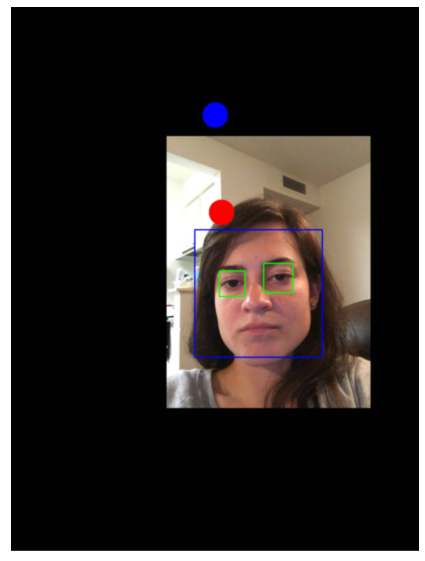

In [295]:
render_gazes(img, outputs)